## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [34]:
import pandas as pd
import numpy as np

myData = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")
myData.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create raget and predictor variables and split
X = myData[["age", "chol"]]
y = myData["diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create ct
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

# Create logistic pipeline
pipeline_logistic = Pipeline([
    ('preprocessor', ct),
    ('regressor', LogisticRegression(max_iter=1000))
])

# Create grid for tuning
logreg_params = {'regressor__C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='roc_auc')
best_logreg = logreg_grid.fit(X_train, y_train)

''' Process for grabbing coefficients and intercept:

# Get the preprocessor from the pipeline
preprocessor = best_logreg.best_estimator_.named_steps['preprocessor']
# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()
# Get the logistic regression coefficients
logreg_coef = best_logreg.best_estimator_.named_steps['regressor'].coef_[0]  # Assuming binary classification
# Extract the intercept
intercept = best_logreg.best_estimator_.named_steps["regressor"].intercept_[0]
print("intercept:", intercept)
# Combine feature names and coefficients into a dictionary or DataFrame
coefficients = dict(zip(feature_names, logreg_coef))
# Display the coefficients
for feature, coef in coefficients.items():
    print(f"{feature}: {coef}")'''

# Get the range of cholesterol values in myData
chol_min = myData["chol"].min()
chol_max = 3000

# Generate a DataFrame of fake people
num_fake_people = 1000  
fake_data = pd.DataFrame({
    "age": [55] * num_fake_people,
    "chol": np.random.uniform(chol_min, chol_max, num_fake_people)
})

# Predict probabilities of heart disease using the pipeline
fake_data["heart_disease_prob"] = best_logreg.predict_proba(fake_data)[:, 1]

# Predict heart disease presence (1 for disease, 0 for no disease)
fake_data["heart_disease_pred_50"] = (fake_data["heart_disease_prob"] >= 0.5).astype(int)
fake_data["heart_disease_pred_50"] = fake_data["heart_disease_pred_50"].map({0: "No Disease", 1: "Disease"})

# Find 90% cut off point
fake_data["heart_disease_pred_90"] = (fake_data["heart_disease_prob"] >= 0.9).astype(int)
fake_data["heart_disease_pred_90"] = fake_data["heart_disease_pred_90"].map({0: "No Disease", 1: "Disease"})

chol_50 = fake_data[fake_data["heart_disease_prob"] >= 0.5]["chol"].min()
chol_90 = fake_data[fake_data["heart_disease_prob"] >= 0.9]["chol"].min()

# Display the fake data with predictions
fake_data.head()


,age,chol,heart_disease_prob,heart_disease_pred_50,heart_disease_pred_90
0,55,2677.350312,0.961684,Disease,Disease
1,55,2791.529523,0.967217,Disease,Disease
2,55,1701.834241,0.863122,Disease,No Disease
3,55,1775.266527,0.874949,Disease,No Disease
4,55,770.155255,0.627658,Disease,No Disease


Now that we have the predictions for heart disease based on 50% and 90% probability for 55 year olds, we can plot the probabilities to cholesterol and color by classification to see cutoff point. 

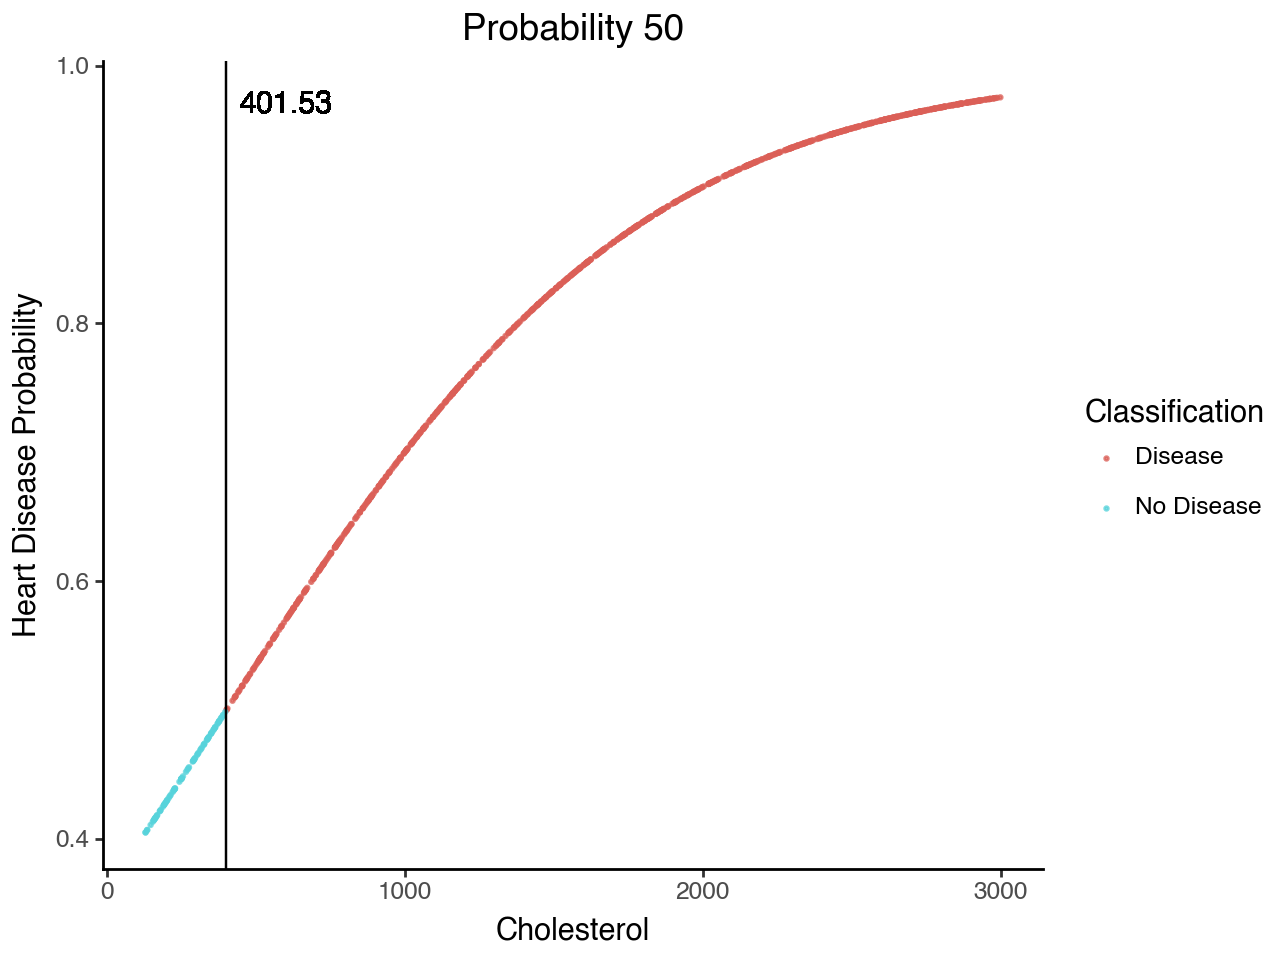

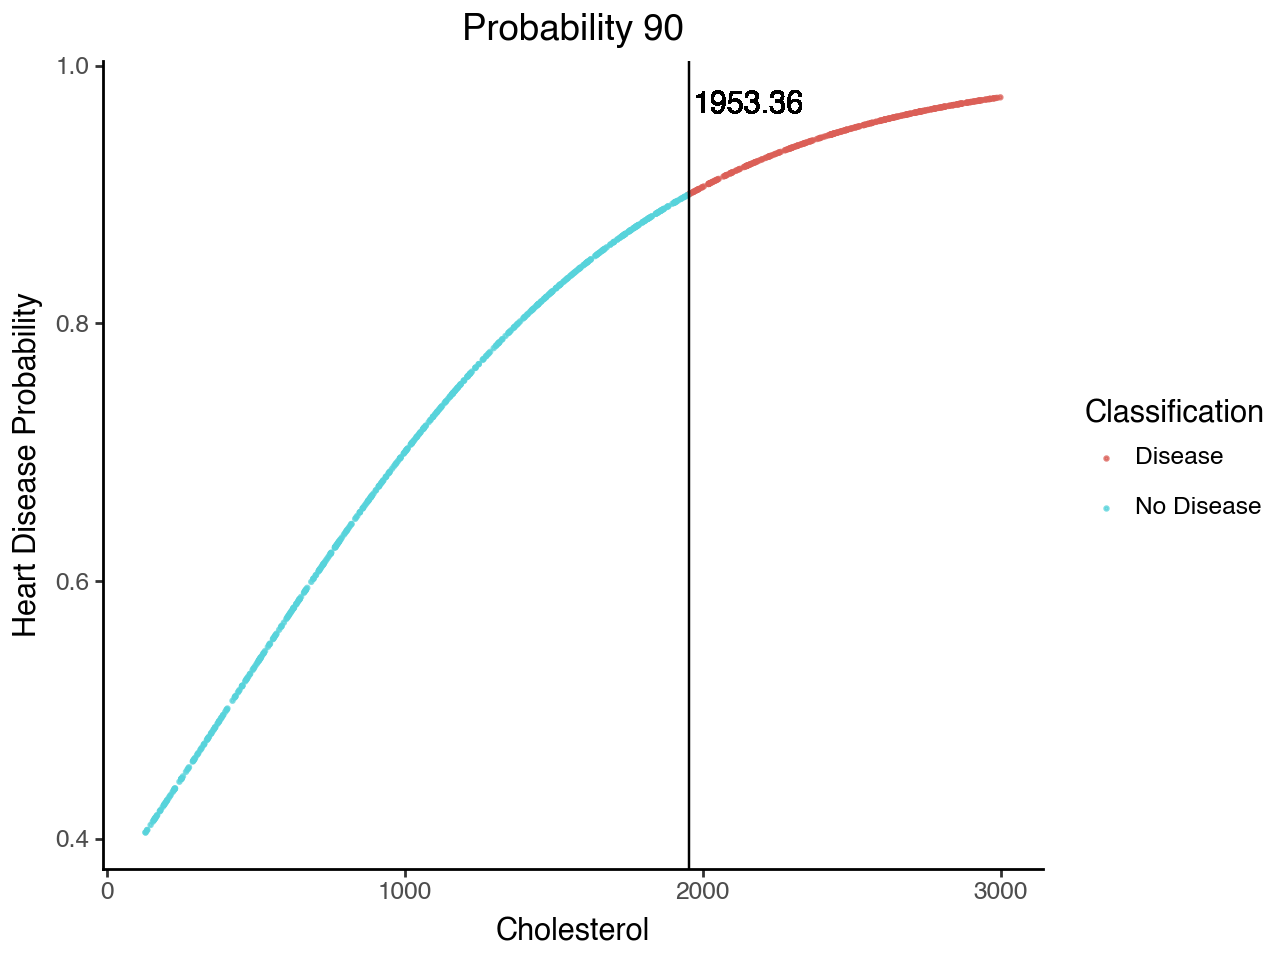

In [36]:
from plotnine import ggplot, aes, geom_point, geom_vline, geom_text, labs, theme_classic, scale_x_continuous, scale_color_manual, geom_line

plot_50 = (
    ggplot(fake_data, aes(x= "chol", y= "heart_disease_prob", color= "heart_disease_pred_50")) +
geom_point(size = .3, alpha= .75) +
geom_vline(xintercept=chol_50) +
geom_text(aes(x=chol_50 + 200, y=0.97, label=f"{chol_50:.2f}"), color= "black") +
labs(
        title='Probability 50',
        x='Cholesterol',
        y='Heart Disease Probability',
        color='Classification'
    ) +
theme_classic() 
)

plot_50.show()

plot_90 = (
    ggplot(fake_data, aes(x= "chol", y= "heart_disease_prob", color= "heart_disease_pred_90")) +
geom_point(size = .3, alpha= .75) +
geom_vline(xintercept=chol_90) +
geom_text(aes(x=chol_90 + 200, y=0.97, label=f"{chol_90:.2f}"), color= "black") +
labs(
        title='Probability 90',
        x='Cholesterol',
        y='Heart Disease Probability',
        color='Classification'
    ) +
theme_classic() 
)

plot_90.show()

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create logistic pipeline
pipeline_logistic = Pipeline([
    ('preprocessor', ct),
    ('regressor', LinearDiscriminantAnalysis())
])

# Set up grid for tuning
param_grid = {
    'regressor__solver': ['svd', 'lsqr', 'eigen'],
    'regressor__n_components': [1]  # For binary classification, typically 1
}
# Create the GridSearchCV object
lda_grid = GridSearchCV(pipeline_logistic, param_grid, cv=5, scoring='roc_auc')
# Fit the model
best_lda = lda_grid.fit(X_train, y_train)

fake_data = fake_data.drop(columns= ["heart_disease_prob", "heart_disease_pred_50", "heart_disease_pred_90"])
# Predict probabilities of heart disease using the pipeline
fake_data["heart_disease_prob"] = best_lda.predict_proba(fake_data)[:, 1]
# Predict heart disease presence (1 for disease, 0 for no disease)
fake_data["heart_disease_pred_50"] = (fake_data["heart_disease_prob"] >= 0.5).astype(int)
fake_data["heart_disease_pred_50"] = fake_data["heart_disease_pred_50"].map({0: "No Disease", 1: "Disease"})
# Find 90% cut off point
fake_data["heart_disease_pred_90"] = (fake_data["heart_disease_prob"] >= 0.9).astype(int)
fake_data["heart_disease_pred_90"] = fake_data["heart_disease_pred_90"].map({0: "No Disease", 1: "Disease"})

chol_50 = fake_data[fake_data["heart_disease_prob"] >= 0.5]["chol"].min()
chol_90 = fake_data[fake_data["heart_disease_prob"] >= 0.9]["chol"].min()

# Display the fake data with predictions
fake_data.head()

,age,chol,heart_disease_prob,heart_disease_pred_50,heart_disease_pred_90
0,55,2677.350312,0.999960,Disease,Disease
1,55,2791.529523,0.999975,Disease,Disease
2,55,1701.834241,0.997527,Disease,Disease
3,55,1775.266527,0.998186,Disease,Disease
4,55,770.155255,0.887066,Disease,No Disease


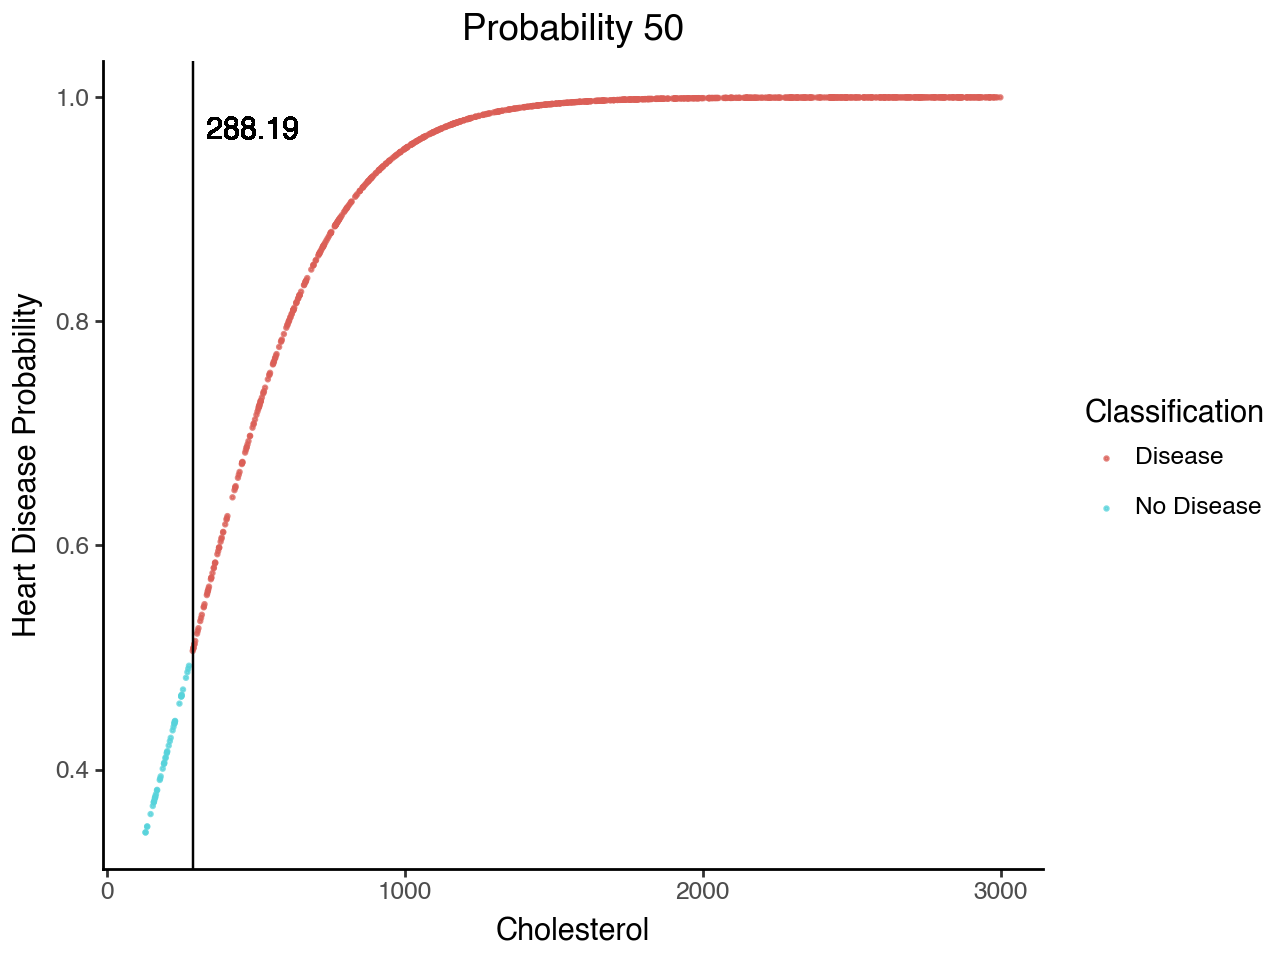

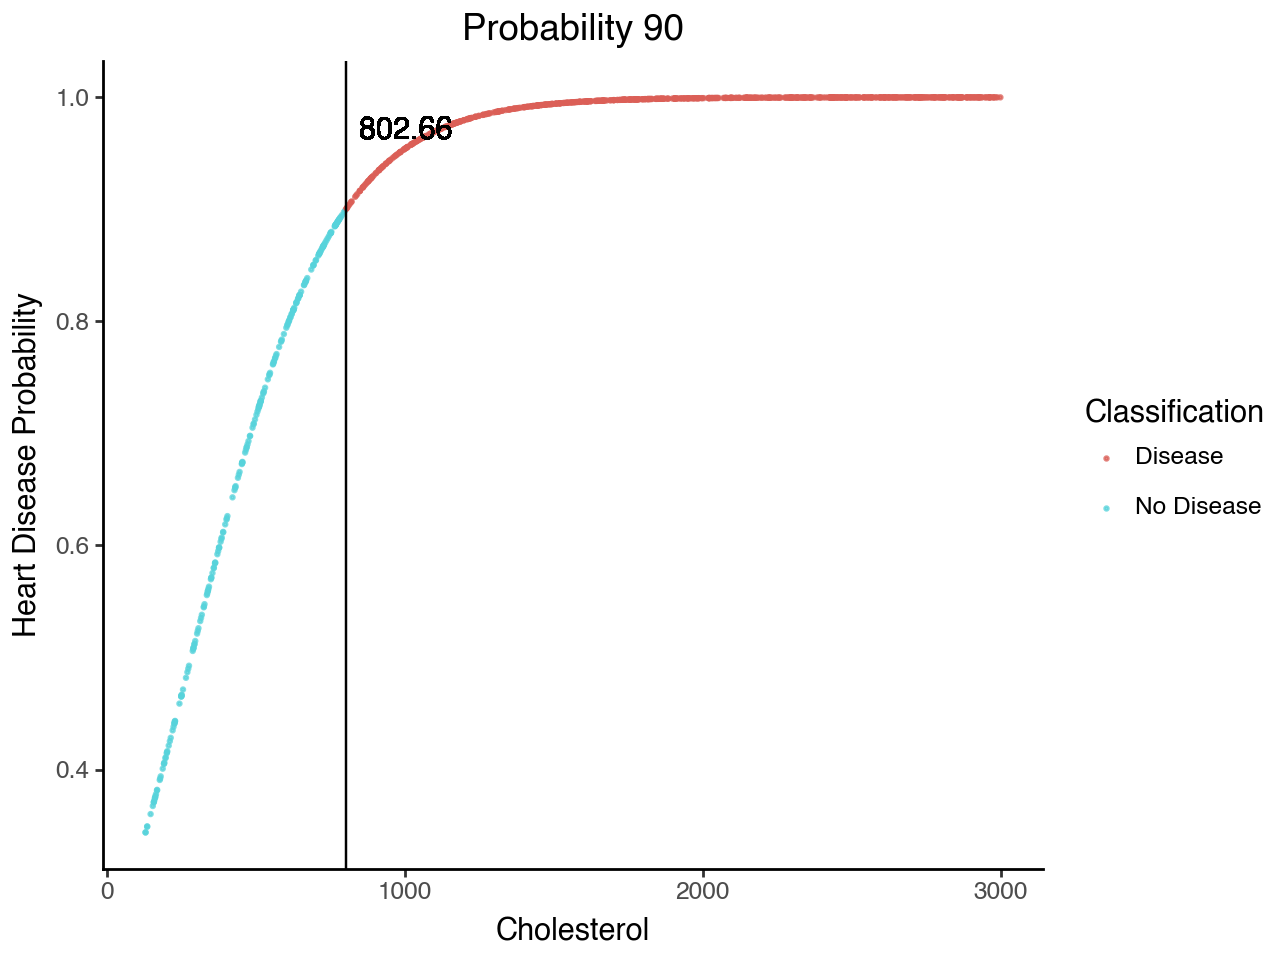

In [38]:
plot_50 = (
    ggplot(fake_data, aes(x= "chol", y= "heart_disease_prob", color= "heart_disease_pred_50")) +
geom_point(size = .3, alpha= .75) +
geom_vline(xintercept=chol_50) +
geom_text(aes(x=chol_50 + 200, y=0.97, label=f"{chol_50:.2f}"), color= "black") +
labs(
        title='Probability 50',
        x='Cholesterol',
        y='Heart Disease Probability',
        color='Classification'
    ) +
theme_classic() 
)

plot_50.show()

plot_90 = (
    ggplot(fake_data, aes(x= "chol", y= "heart_disease_prob", color= "heart_disease_pred_90")) +
geom_point(size = .3, alpha= .75) +
geom_vline(xintercept=chol_90) +
geom_text(aes(x=chol_90 + 200, y=0.97, label=f"{chol_90:.2f}"), color= "black") +
labs(
        title='Probability 90',
        x='Cholesterol',
        y='Heart Disease Probability',
        color='Classification'
    ) +
theme_classic() 
)

plot_90.show()

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [44]:
from sklearn.svm import SVC

y = y.replace({0: -1, 1: 1})

# Define pipeline for SVC model
pipeline_svc = Pipeline([
    ('preprocessor', ct),
    ('regressor', SVC(probability=True, kernel= "linear"))  # SVC with probability enabled
])

# Set up parameter grid to tune the regularization parameter 'C'
param_grid = {
    'regressor__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter
}
svc_grid = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring='roc_auc')
# Fit the model
best_svc = svc_grid.fit(X_train, y_train)

fake_data = fake_data.drop(columns= ["heart_disease_prob", "heart_disease_pred_50", "heart_disease_pred_90"])
# Predict probabilities of heart disease using the pipeline
fake_data["heart_disease_prob"] = best_svc.predict_proba(fake_data)[:, 1]
# Predict heart disease presence (1 for disease, 0 for no disease)
fake_data["heart_disease_pred_50"] = (fake_data["heart_disease_prob"] >= 0.5).astype(int)
fake_data["heart_disease_pred_50"] = fake_data["heart_disease_pred_50"].map({0: "No Disease", 1: "Disease"})
# Find 90% cut off point
fake_data["heart_disease_pred_90"] = (fake_data["heart_disease_prob"] >= 0.9).astype(int)
fake_data["heart_disease_pred_90"] = fake_data["heart_disease_pred_90"].map({0: "No Disease", 1: "Disease"})

chol_50_down = fake_data[fake_data["heart_disease_prob"] >= 0.5]["chol"].min()
chol_50_up = fake_data[fake_data["heart_disease_prob"] >= 0.5]["chol"].max()

# Display the fake data with predictions
fake_data.head()

,age,chol,heart_disease_prob,heart_disease_pred_50,heart_disease_pred_90
0,55,2677.350312,0.992379,Disease,Disease
1,55,2791.529523,0.993972,Disease,Disease
2,55,1701.834241,0.945468,Disease,Disease
3,55,1775.266527,0.952780,Disease,Disease
4,55,770.155255,0.715988,Disease,No Disease


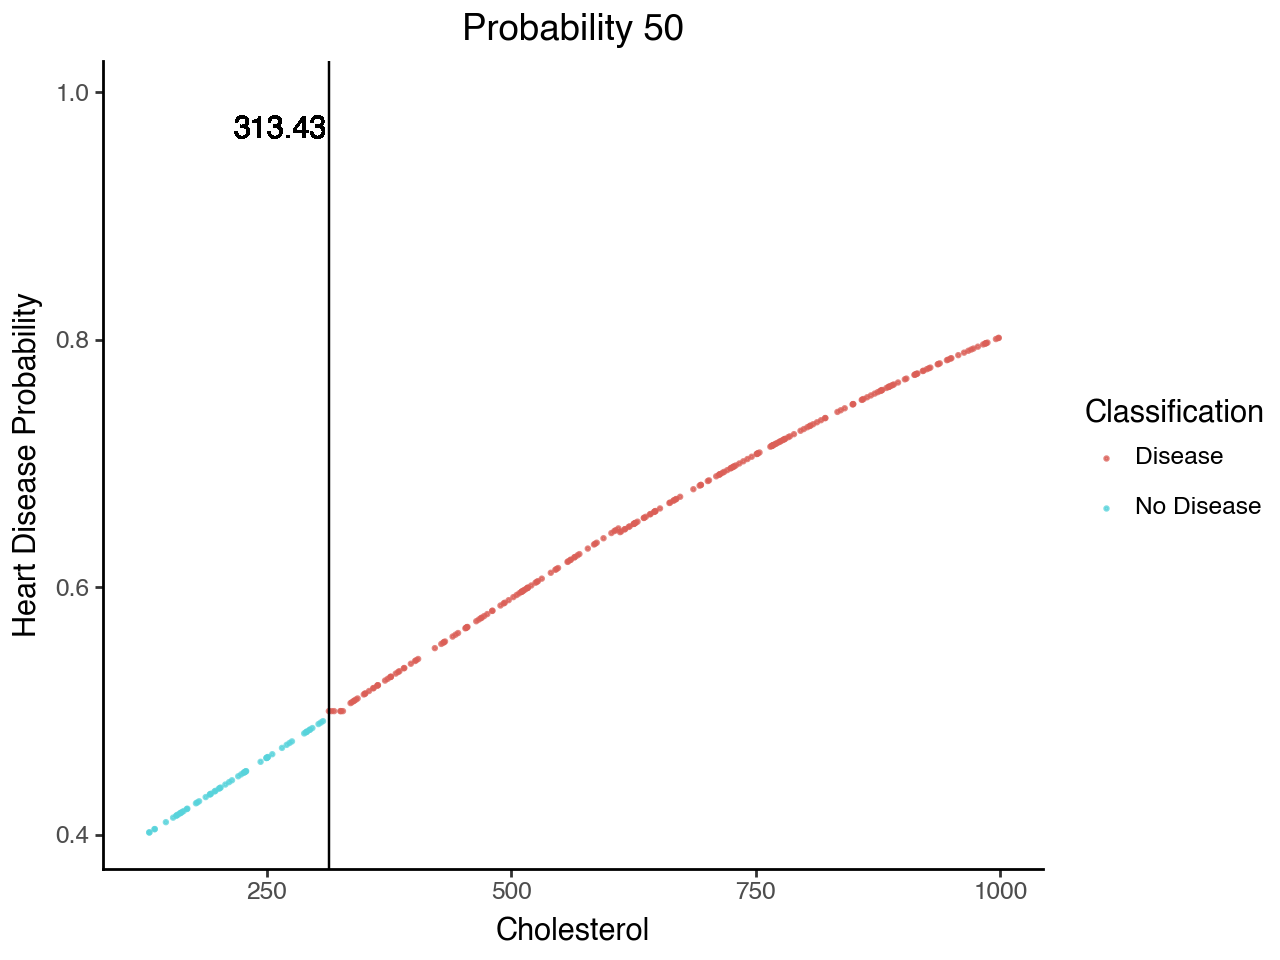

In [45]:
import warnings
warnings.filterwarnings("ignore", message="geom_point : Removed .* rows containing missing values")
warnings.filterwarnings("ignore", message="geom_vline : Removed .* rows containing missing values")
warnings.filterwarnings("ignore", message="geom_text : Removed .* rows containing missing values")

# Remove rows with NaN values in relevant columns
fake_data = fake_data.dropna()


plot_50 = (
    ggplot(fake_data, aes(x= "chol", y= "heart_disease_prob", color= "heart_disease_pred_50")) +
geom_point(size = .3, alpha= .75) +
geom_vline(xintercept=chol_50_up) +
geom_vline(xintercept=chol_50_down) +
scale_x_continuous(limits=(chol_min, 1000)) +
geom_text(aes(x=chol_50_up + 55, y=0.97, label=f"{chol_50_up:.2f}"), color= "black") +
geom_text(aes(x=chol_50_down - 50, y=0.97, label=f"{chol_50_down:.2f}"), color= "black") +
labs(
        title='Probability 50',
        x='Cholesterol',
        y='Heart Disease Probability',
        color='Classification'
    ) +
theme_classic() 
)

plot_50.show()

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

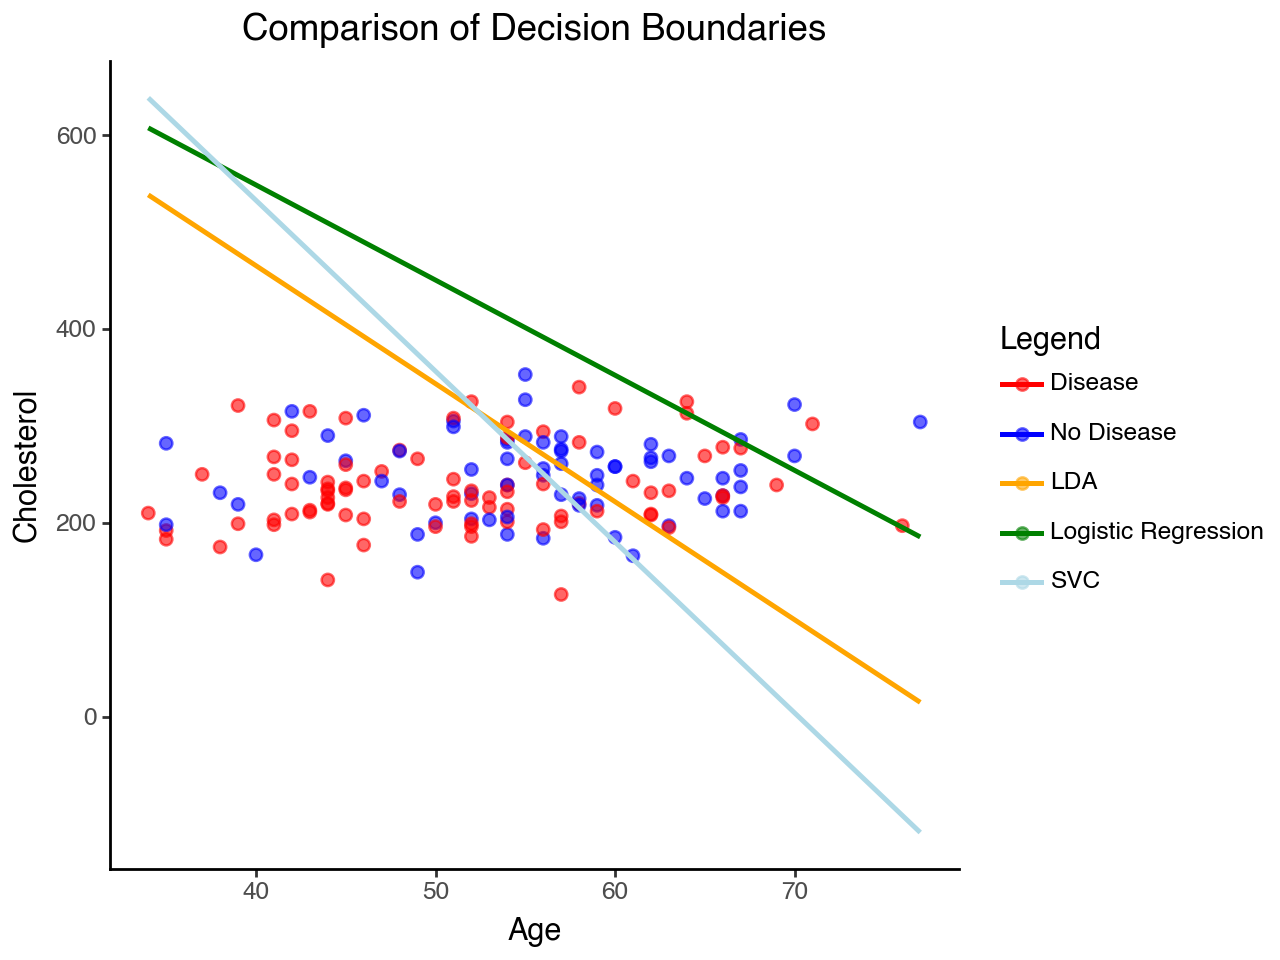

In [42]:
# Scatterplot data
plot_data = X_train.copy()
plot_data['true_outcome'] = y_train

# Extract scaling parameters
scaler = best_logreg.best_estimator_.named_steps["preprocessor"].named_transformers_["standardize"]
age_mean, age_scale = scaler.mean_[0], scaler.scale_[0]  # Assuming 'age' is the first column
chol_mean, chol_scale = scaler.mean_[1], scaler.scale_[1]  # Assuming 'chol' is the second column

# Generate decision boundary points
age_range = np.linspace(X_train['age'].min(), X_train['age'].max(), 500)

# Logistic Regression decision boundary (Unscale coefficients)
logreg_model = best_logreg.best_estimator_.named_steps["regressor"]
b0_log = logreg_model.intercept_[0]
b1_log, b2_log = logreg_model.coef_[0]  # Assuming age and chol are in this order
b1_log_unscaled = b1_log / age_scale
b2_log_unscaled = b2_log / chol_scale
b0_log_unscaled = b0_log - b1_log_unscaled * age_mean - b2_log_unscaled * chol_mean

chol_log = -(b0_log_unscaled + b1_log_unscaled * age_range) / b2_log_unscaled
log_boundary = pd.DataFrame({'age': age_range, 'chol': chol_log, 'model': 'Logistic Regression'})

# LDA decision boundary (Unscale coefficients)
lda_model = best_lda.best_estimator_.named_steps["regressor"]
b0_lda = lda_model.intercept_[0]
b1_lda, b2_lda = lda_model.coef_[0]
b1_lda_unscaled = b1_lda / age_scale
b2_lda_unscaled = b2_lda / chol_scale
b0_lda_unscaled = b0_lda - b1_lda_unscaled * age_mean - b2_lda_unscaled * chol_mean

chol_lda = -(b0_lda_unscaled + b1_lda_unscaled * age_range) / b2_lda_unscaled
lda_boundary = pd.DataFrame({'age': age_range, 'chol': chol_lda, 'model': 'LDA'})

# SVC decision boundary (Unscale coefficients)
svc_model = best_svc.best_estimator_.named_steps["regressor"]
b0_svc = svc_model.intercept_[0]
b1_svc, b2_svc = svc_model.coef_[0]
b1_svc_unscaled = b1_svc / age_scale
b2_svc_unscaled = b2_svc / chol_scale
b0_svc_unscaled = b0_svc - b1_svc_unscaled * age_mean - b2_svc_unscaled * chol_mean

chol_svc = -(b0_svc_unscaled + b1_svc_unscaled * age_range) / b2_svc_unscaled
svc_boundary = pd.DataFrame({'age': age_range, 'chol': chol_svc, 'model': 'SVC'})

# Combine decision boundaries
boundaries = pd.concat([log_boundary, lda_boundary, svc_boundary])

# Create the plot
plot = (
    ggplot(plot_data, aes(x='age', y='chol', color='true_outcome')) +
    geom_point(alpha=0.6, size=2) +
    geom_line(boundaries, aes(x='age', y='chol', color='model'), size=1) +
    scale_color_manual(
        values={'No Disease': 'blue', 'Disease': 'red', 'Logistic Regression': 'green', 'LDA': 'orange', 'SVC': 'lightblue'},
        name="Legend"
    ) +
    labs(
        title="Comparison of Decision Boundaries",
        x="Age",
        y="Cholesterol"
    ) +
    theme_classic()
)

# Display the plot
plot.show()
